In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Sep 14 11:10:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 18%   51C    P2              60W / 250W |   1186MiB / 11264MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [5]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1,wrapper_kwargs={"clip_reward":False})
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(1154, 4, 84, 84) (1154,) (1154,) (1154,) (1154,) (1154, 4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(1, 4, 84, 84)


In [6]:
obs = env.reset()
print(obs.shape)

(1, 4, 84, 84)


In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)

# prev = PolicyNetwork(env.action_space.n).to(device)
# prev.load_state_dict(policy_network.state_dict())
# prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean()
std=observations.std()
print(mean.shape, std.shape)

Normlization=True
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
        # with torch.no_grad():
        #     prev_dist = Categorical(logits=prev(obs_batch))
        #     reference_chosen_logps = prev_dist.log_prob(act_batch)
        #     reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
        # ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 0.1
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    # losses = (-F.logsigmoid(beta * logits))
    losses = -policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})

    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
            if not saved_frame:
                saved_frame = True
                image_path = f"test_{epoch}.gif"
                imageio.mimsave("./gif/"+image_path, frames, duration=40)
        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



() ()


  0%|          | 496/100000 [00:10<34:27, 48.13it/s] /mnt/nfs/work/c98181/miniconda3/envs/atari/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
  1%|          | 506/100000 [00:14<4:47:16,  5.77it/s]

Epoch [500/100000] loss: 0.03753118962049484 positive_reward: -0.03753118962049484 negative_reward: -0.103196881711483 margin: 0.06566569209098816 test_score: [580.]


  1%|          | 1006/100000 [00:29<5:19:57,  5.16it/s]

Epoch [1000/100000] loss: 0.047597624361515045 positive_reward: -0.047597624361515045 negative_reward: -0.16508987545967102 margin: 0.11749225109815598 test_score: [1800.]


  2%|▏         | 1505/100000 [00:53<15:37:33,  1.75it/s]

Epoch [1500/100000] loss: 0.02376037836074829 positive_reward: -0.02376037836074829 negative_reward: -0.08656886219978333 margin: 0.06280848383903503 test_score: [3240.]


  2%|▏         | 2005/100000 [01:16<8:44:06,  3.12it/s] 

Epoch [2000/100000] loss: 0.039079032838344574 positive_reward: -0.039079032838344574 negative_reward: -0.14368107914924622 margin: 0.10460204631090164 test_score: [1160.]


  3%|▎         | 2505/100000 [01:42<13:28:22,  2.01it/s]

Epoch [2500/100000] loss: 0.021709343418478966 positive_reward: -0.021709343418478966 negative_reward: -0.11080336570739746 margin: 0.0890940222889185 test_score: [930.]


  3%|▎         | 3002/100000 [02:02<5:40:47,  4.74it/s] 

Epoch [3000/100000] loss: 0.01628326252102852 positive_reward: -0.01628326252102852 negative_reward: -0.07527222484350204 margin: 0.058988962322473526 test_score: [310.]


  4%|▎         | 3504/100000 [02:25<7:03:18,  3.80it/s]

Epoch [3500/100000] loss: 0.04342271760106087 positive_reward: -0.04342271760106087 negative_reward: -0.13493047654628754 margin: 0.09150775894522667 test_score: [620.]


  4%|▍         | 4004/100000 [02:49<8:41:26,  3.07it/s]

Epoch [4000/100000] loss: 0.021275201812386513 positive_reward: -0.021275201812386513 negative_reward: -0.09042567759752274 margin: 0.06915047578513622 test_score: [2200.]


  5%|▍         | 4504/100000 [03:11<5:45:06,  4.61it/s]

Epoch [4500/100000] loss: 0.015344543382525444 positive_reward: -0.015344543382525444 negative_reward: -0.05708117410540581 margin: 0.04173663072288036 test_score: [1670.]


  5%|▌         | 5005/100000 [03:33<4:48:35,  5.49it/s]

Epoch [5000/100000] loss: 0.35277098417282104 positive_reward: -0.35277098417282104 negative_reward: -0.6968557238578796 margin: 0.3440847396850586 test_score: [650.]


  6%|▌         | 5504/100000 [03:54<5:23:17,  4.87it/s]

Epoch [5500/100000] loss: 0.028511803597211838 positive_reward: -0.028511803597211838 negative_reward: -0.10846255719661713 margin: 0.07995075359940529 test_score: [670.]


  6%|▌         | 6005/100000 [04:17<5:52:37,  4.44it/s]

Epoch [6000/100000] loss: 0.016590332612395287 positive_reward: -0.016590332612395287 negative_reward: -0.06747064739465714 margin: 0.05088031478226185 test_score: [480.]


  7%|▋         | 6503/100000 [04:43<12:51:27,  2.02it/s]

Epoch [6500/100000] loss: 0.012093783356249332 positive_reward: -0.012093783356249332 negative_reward: -0.028620542958378792 margin: 0.01652675960212946 test_score: [3240.]


  7%|▋         | 7002/100000 [05:03<5:23:03,  4.80it/s] 

Epoch [7000/100000] loss: 0.009622287005186081 positive_reward: -0.009622287005186081 negative_reward: -0.03408348560333252 margin: 0.02446119859814644 test_score: [340.]


  8%|▊         | 7502/100000 [05:27<10:08:08,  2.54it/s]

Epoch [7500/100000] loss: 0.04223798215389252 positive_reward: -0.04223798215389252 negative_reward: -0.13080206513404846 margin: 0.08856408298015594 test_score: [3240.]


  8%|▊         | 8005/100000 [05:50<7:40:17,  3.33it/s] 

Epoch [8000/100000] loss: 0.01684953086078167 positive_reward: -0.01684953086078167 negative_reward: -0.05848931893706322 margin: 0.04163978807628155 test_score: [3210.]


  9%|▊         | 8504/100000 [06:10<4:40:53,  5.43it/s]

Epoch [8500/100000] loss: 0.011562622152268887 positive_reward: -0.011562622152268887 negative_reward: -0.044233448803424835 margin: 0.03267082665115595 test_score: [220.]


  9%|▉         | 9004/100000 [06:32<6:29:05,  3.90it/s]

Epoch [9000/100000] loss: 0.009148040786385536 positive_reward: -0.009148040786385536 negative_reward: -0.05125211179256439 margin: 0.042104071006178856 test_score: [470.]


 10%|▉         | 9503/100000 [06:57<9:33:03,  2.63it/s]

Epoch [9500/100000] loss: 0.008106469176709652 positive_reward: -0.008106469176709652 negative_reward: -0.06143574044108391 margin: 0.053329271264374256 test_score: [2750.]


 10%|█         | 10003/100000 [07:18<6:24:24,  3.90it/s]

Epoch [10000/100000] loss: 0.007174298632889986 positive_reward: -0.007174298632889986 negative_reward: -0.029408948495984077 margin: 0.02223464986309409 test_score: [1050.]


 11%|█         | 10503/100000 [07:40<5:18:39,  4.68it/s]

Epoch [10500/100000] loss: 0.04772351682186127 positive_reward: -0.04772351682186127 negative_reward: -0.1681794673204422 margin: 0.12045595049858093 test_score: [330.]


 11%|█         | 11004/100000 [08:05<8:58:33,  2.75it/s] 

Epoch [11000/100000] loss: 0.015194835141301155 positive_reward: -0.015194835141301155 negative_reward: -0.0872025415301323 margin: 0.07200770638883114 test_score: [3210.]


 12%|█▏        | 11502/100000 [08:26<7:25:36,  3.31it/s]

Epoch [11500/100000] loss: 0.009165906347334385 positive_reward: -0.009165906347334385 negative_reward: -0.04971756413578987 margin: 0.040551657788455486 test_score: [480.]


 12%|█▏        | 12007/100000 [08:45<3:01:26,  8.08it/s]

Epoch [12000/100000] loss: 0.006962466984987259 positive_reward: -0.006962466984987259 negative_reward: -0.027743328362703323 margin: 0.020780861377716064 test_score: [280.]


 13%|█▎        | 12505/100000 [09:08<6:06:13,  3.98it/s] 

Epoch [12500/100000] loss: 0.026360902935266495 positive_reward: -0.026360902935266495 negative_reward: -0.11728905141353607 margin: 0.09092814847826958 test_score: [1850.]


 13%|█▎        | 13007/100000 [09:31<8:01:21,  3.01it/s] 

Epoch [13000/100000] loss: 0.011357821524143219 positive_reward: -0.011357821524143219 negative_reward: -0.05509403720498085 margin: 0.04373621568083763 test_score: [620.]


 14%|█▎        | 13503/100000 [09:55<9:10:05,  2.62it/s] 

Epoch [13500/100000] loss: 0.008247888647019863 positive_reward: -0.008247888647019863 negative_reward: -0.041237831115722656 margin: 0.03298994246870279 test_score: [1680.]


 14%|█▍        | 14004/100000 [10:18<6:49:47,  3.50it/s]

Epoch [14000/100000] loss: 0.03333701938390732 positive_reward: -0.03333701938390732 negative_reward: -0.11748557537794113 margin: 0.08414855599403381 test_score: [600.]


 15%|█▍        | 14502/100000 [10:40<5:08:59,  4.61it/s]

Epoch [14500/100000] loss: 0.009472913108766079 positive_reward: -0.009472913108766079 negative_reward: -0.0572543665766716 margin: 0.04778145346790552 test_score: [410.]


 15%|█▌        | 15004/100000 [11:06<10:46:47,  2.19it/s]

Epoch [15000/100000] loss: 0.007158977910876274 positive_reward: -0.007158977910876274 negative_reward: -0.030817577615380287 margin: 0.023658599704504013 test_score: [3240.]


 16%|█▌        | 15503/100000 [11:27<5:49:32,  4.03it/s] 

Epoch [15500/100000] loss: 0.00607783067971468 positive_reward: -0.00607783067971468 negative_reward: -0.03480370715260506 margin: 0.028725876472890377 test_score: [950.]


 16%|█▌        | 16002/100000 [11:52<10:40:49,  2.18it/s]

Epoch [16000/100000] loss: 0.005611153785139322 positive_reward: -0.005611153785139322 negative_reward: -0.015836523845791817 margin: 0.010225370060652494 test_score: [3240.]


 17%|█▋        | 16505/100000 [12:14<6:31:16,  3.56it/s] 

Epoch [16500/100000] loss: 0.016158869490027428 positive_reward: -0.016158869490027428 negative_reward: -0.054302673786878586 margin: 0.03814380429685116 test_score: [1480.]


 17%|█▋        | 17005/100000 [12:35<6:08:44,  3.75it/s]

Epoch [17000/100000] loss: 0.00872385036200285 positive_reward: -0.00872385036200285 negative_reward: -0.04150627553462982 margin: 0.03278242517262697 test_score: [3550.]


 18%|█▊        | 17503/100000 [13:01<11:31:49,  1.99it/s]

Epoch [17500/100000] loss: 0.006928590591996908 positive_reward: -0.006928590591996908 negative_reward: -0.06097274646162987 margin: 0.05404415586963296 test_score: [3240.]


 18%|█▊        | 18004/100000 [13:21<10:08:59,  2.24it/s]

Epoch [18000/100000] loss: 0.006130583584308624 positive_reward: -0.006130583584308624 negative_reward: -0.023229829967021942 margin: 0.017099246382713318 test_score: [280.]


 19%|█▊        | 18505/100000 [13:41<7:59:28,  2.83it/s] 

Epoch [18500/100000] loss: 0.005767284892499447 positive_reward: -0.005767284892499447 negative_reward: -0.05686642602086067 margin: 0.051099141128361225 test_score: [250.]


 19%|█▉        | 19005/100000 [14:03<11:00:47,  2.04it/s]

Epoch [19000/100000] loss: 0.005498585291206837 positive_reward: -0.005498585291206837 negative_reward: -0.017087088897824287 margin: 0.01158850360661745 test_score: [1090.]


 20%|█▉        | 19504/100000 [14:23<9:31:54,  2.35it/s] 

Epoch [19500/100000] loss: 0.12886375188827515 positive_reward: -0.12886375188827515 negative_reward: -0.2708840072154999 margin: 0.14202025532722473 test_score: [710.]


 20%|██        | 20005/100000 [14:43<5:12:30,  4.27it/s]

Epoch [20000/100000] loss: 0.005272647365927696 positive_reward: -0.005272647365927696 negative_reward: -0.04833872988820076 margin: 0.043066082522273064 test_score: [4090.]


 21%|██        | 20503/100000 [15:04<11:11:20,  1.97it/s]

Epoch [20500/100000] loss: 0.00407005287706852 positive_reward: -0.00407005287706852 negative_reward: -0.024623923003673553 margin: 0.020553870126605034 test_score: [3240.]


 21%|██        | 21005/100000 [15:30<16:24:29,  1.34it/s]

Epoch [21000/100000] loss: 0.004175620619207621 positive_reward: -0.004175620619207621 negative_reward: -0.015484455972909927 margin: 0.011308835353702307 test_score: [3240.]


 22%|██▏       | 21507/100000 [15:53<5:30:47,  3.95it/s] 

Epoch [21500/100000] loss: 0.018913784995675087 positive_reward: -0.018913784995675087 negative_reward: -0.07718160003423691 margin: 0.05826781503856182 test_score: [420.]


 22%|██▏       | 22005/100000 [16:16<8:47:39,  2.46it/s] 

Epoch [22000/100000] loss: 0.005244140978902578 positive_reward: -0.005244140978902578 negative_reward: -0.02220729924738407 margin: 0.016963158268481493 test_score: [1150.]


 23%|██▎       | 22505/100000 [16:37<6:11:53,  3.47it/s] 

Epoch [22500/100000] loss: 0.004405404906719923 positive_reward: -0.004405404906719923 negative_reward: -0.025613244622945786 margin: 0.021207839716225863 test_score: [390.]


 23%|██▎       | 23006/100000 [17:00<7:04:27,  3.02it/s] 

Epoch [23000/100000] loss: 0.0042446693405508995 positive_reward: -0.0042446693405508995 negative_reward: -0.019919006153941154 margin: 0.015674336813390255 test_score: [730.]


 24%|██▎       | 23503/100000 [17:25<10:28:51,  2.03it/s]

Epoch [23500/100000] loss: 0.03559032082557678 positive_reward: -0.03559032082557678 negative_reward: -0.1421719193458557 margin: 0.10658159852027893 test_score: [2310.]


 24%|██▍       | 24002/100000 [17:46<5:34:07,  3.79it/s] 

Epoch [24000/100000] loss: 0.006009597796946764 positive_reward: -0.006009597796946764 negative_reward: -0.0547465905547142 margin: 0.04873699275776744 test_score: [1900.]


 25%|██▍       | 24504/100000 [18:13<8:11:00,  2.56it/s] 

Epoch [24500/100000] loss: 0.004836194682866335 positive_reward: -0.004836194682866335 negative_reward: -0.020996510982513428 margin: 0.016160316299647093 test_score: [3240.]


 25%|██▌       | 25001/100000 [18:34<6:28:53,  3.21it/s]

Epoch [25000/100000] loss: 0.004521794151514769 positive_reward: -0.004521794151514769 negative_reward: -0.06521377712488174 margin: 0.060691982973366976 test_score: [2260.]


 26%|██▌       | 25504/100000 [18:58<6:42:07,  3.09it/s]

Epoch [25500/100000] loss: 0.0045132930390536785 positive_reward: -0.0045132930390536785 negative_reward: -0.028169790282845497 margin: 0.02365649724379182 test_score: [3240.]


 26%|██▌       | 26006/100000 [19:20<3:04:42,  6.68it/s]

Epoch [26000/100000] loss: 0.006181445438414812 positive_reward: -0.006181445438414812 negative_reward: -0.017075318843126297 margin: 0.010893873404711485 test_score: [330.]


 27%|██▋       | 26506/100000 [19:42<4:26:50,  4.59it/s]

Epoch [26500/100000] loss: 0.6371520161628723 positive_reward: -0.6371520161628723 negative_reward: -0.49541613459587097 margin: -0.14173588156700134 test_score: [330.]


 27%|██▋       | 27007/100000 [20:04<4:56:37,  4.10it/s]

Epoch [27000/100000] loss: 0.005223125219345093 positive_reward: -0.005223125219345093 negative_reward: -0.011724541895091534 margin: 0.006501416675746441 test_score: [270.]


 28%|██▊       | 27503/100000 [20:28<7:17:48,  2.76it/s] 

Epoch [27500/100000] loss: 0.004060693550854921 positive_reward: -0.004060693550854921 negative_reward: -0.03913038969039917 margin: 0.03506969613954425 test_score: [440.]


 28%|██▊       | 28004/100000 [20:54<9:37:13,  2.08it/s] 

Epoch [28000/100000] loss: 0.005682308226823807 positive_reward: -0.005682308226823807 negative_reward: -0.03687978908419609 margin: 0.031197480857372284 test_score: [2700.]


 29%|██▊       | 28502/100000 [21:17<8:45:47,  2.27it/s]

Epoch [28500/100000] loss: 0.003725001122802496 positive_reward: -0.003725001122802496 negative_reward: -0.011750378645956516 margin: 0.00802537752315402 test_score: [3190.]


 29%|██▉       | 29003/100000 [21:39<7:08:14,  2.76it/s]

Epoch [29000/100000] loss: 0.0037026843056082726 positive_reward: -0.0037026843056082726 negative_reward: -0.014384393580257893 margin: 0.01068170927464962 test_score: [1360.]


 30%|██▉       | 29504/100000 [22:00<5:01:55,  3.89it/s]

Epoch [29500/100000] loss: 0.003931428771466017 positive_reward: -0.003931428771466017 negative_reward: -0.03306853771209717 margin: 0.02913710894063115 test_score: [500.]


 30%|███       | 30007/100000 [22:24<5:50:44,  3.33it/s]

Epoch [30000/100000] loss: 0.004080018028616905 positive_reward: -0.004080018028616905 negative_reward: -0.012109440751373768 margin: 0.008029422722756863 test_score: [3240.]


 31%|███       | 30506/100000 [22:46<5:59:19,  3.22it/s]

Epoch [30500/100000] loss: 0.004166232887655497 positive_reward: -0.004166232887655497 negative_reward: -0.016693836078047752 margin: 0.012527603190392256 test_score: [350.]


 31%|███       | 31006/100000 [23:09<5:39:25,  3.39it/s]

Epoch [31000/100000] loss: 0.004211849998682737 positive_reward: -0.004211849998682737 negative_reward: -0.040701787918806076 margin: 0.03648993792012334 test_score: [1100.]


 32%|███▏      | 31507/100000 [23:30<4:33:18,  4.18it/s]

Epoch [31500/100000] loss: 0.1104101911187172 positive_reward: -0.1104101911187172 negative_reward: -0.304135262966156 margin: 0.1937250718474388 test_score: [320.]


 32%|███▏      | 32006/100000 [23:54<6:07:06,  3.09it/s] 

Epoch [32000/100000] loss: 0.005896895658224821 positive_reward: -0.005896895658224821 negative_reward: -0.03514212742447853 margin: 0.02924523176625371 test_score: [1970.]


 33%|███▎      | 32505/100000 [24:18<7:35:22,  2.47it/s] 

Epoch [32500/100000] loss: 0.004565556067973375 positive_reward: -0.004565556067973375 negative_reward: -0.03848322108387947 margin: 0.033917665015906096 test_score: [450.]


 33%|███▎      | 33004/100000 [24:43<8:01:27,  2.32it/s]

Epoch [33000/100000] loss: 0.005492126569151878 positive_reward: -0.005492126569151878 negative_reward: -0.022283324971795082 margin: 0.016791198402643204 test_score: [3240.]


 34%|███▎      | 33504/100000 [25:06<4:33:32,  4.05it/s]

Epoch [33500/100000] loss: 0.0037737723905593157 positive_reward: -0.0037737723905593157 negative_reward: -0.03235345706343651 margin: 0.028579684672877192 test_score: [810.]


 34%|███▍      | 34007/100000 [25:29<4:03:51,  4.51it/s]

Epoch [34000/100000] loss: 0.0035413051955401897 positive_reward: -0.0035413051955401897 negative_reward: -0.015132682397961617 margin: 0.011591377202421427 test_score: [420.]


 35%|███▍      | 34505/100000 [25:53<9:20:02,  1.95it/s] 

Epoch [34500/100000] loss: 0.0036489570047706366 positive_reward: -0.0036489570047706366 negative_reward: -0.03358513489365578 margin: 0.02993617788888514 test_score: [580.]


 35%|███▌      | 35003/100000 [26:17<6:07:51,  2.94it/s]

Epoch [35000/100000] loss: 0.003755632322281599 positive_reward: -0.003755632322281599 negative_reward: -0.008841716684401035 margin: 0.005086084362119436 test_score: [1340.]


 36%|███▌      | 35504/100000 [26:40<4:45:45,  3.76it/s]

Epoch [35500/100000] loss: 0.04135837405920029 positive_reward: -0.04135837405920029 negative_reward: -0.1471697837114334 margin: 0.10581140965223312 test_score: [430.]


 36%|███▌      | 36004/100000 [27:03<3:54:39,  4.55it/s]

Epoch [36000/100000] loss: 0.005777540151029825 positive_reward: -0.005777540151029825 negative_reward: -0.02573707140982151 margin: 0.019959531258791685 test_score: [430.]


 37%|███▋      | 36507/100000 [27:26<3:49:18,  4.61it/s]

Epoch [36500/100000] loss: 0.004865133203566074 positive_reward: -0.004865133203566074 negative_reward: -0.03539617359638214 margin: 0.030531040392816067 test_score: [390.]


 37%|███▋      | 37007/100000 [27:52<8:10:31,  2.14it/s] 

Epoch [37000/100000] loss: 0.0037669383455067873 positive_reward: -0.0037669383455067873 negative_reward: -0.023383552208542824 margin: 0.019616613863036036 test_score: [3240.]


 38%|███▊      | 37505/100000 [28:16<4:34:12,  3.80it/s]

Epoch [37500/100000] loss: 0.0036091648507863283 positive_reward: -0.0036091648507863283 negative_reward: -0.016911953687667847 margin: 0.013302788836881518 test_score: [370.]


 38%|███▊      | 38005/100000 [28:38<5:48:29,  2.96it/s]

Epoch [38000/100000] loss: 0.0036652348935604095 positive_reward: -0.0036652348935604095 negative_reward: -0.009859775193035603 margin: 0.006194540299475193 test_score: [290.]


 39%|███▊      | 38505/100000 [29:03<11:35:09,  1.47it/s]

Epoch [38500/100000] loss: 0.0037626128178089857 positive_reward: -0.0037626128178089857 negative_reward: -0.036109037697315216 margin: 0.03234642487950623 test_score: [3240.]


 39%|███▉      | 39005/100000 [29:25<4:43:38,  3.58it/s] 

Epoch [39000/100000] loss: 0.0038115018978714943 positive_reward: -0.0038115018978714943 negative_reward: -0.028331277891993523 margin: 0.02451977599412203 test_score: [500.]


 40%|███▉      | 39505/100000 [29:48<4:48:16,  3.50it/s]

Epoch [39500/100000] loss: 0.003872417379170656 positive_reward: -0.003872417379170656 negative_reward: -0.02443665824830532 margin: 0.020564240869134665 test_score: [660.]


 40%|████      | 40007/100000 [30:11<6:01:22,  2.77it/s] 

Epoch [40000/100000] loss: 0.0038968054577708244 positive_reward: -0.0038968054577708244 negative_reward: -0.012989290058612823 margin: 0.009092484600841999 test_score: [990.]


 41%|████      | 40506/100000 [30:34<4:06:11,  4.03it/s]

Epoch [40500/100000] loss: 0.008568238466978073 positive_reward: -0.008568238466978073 negative_reward: -0.05183533951640129 margin: 0.04326710104942322 test_score: [850.]


 41%|████      | 41005/100000 [30:57<6:14:58,  2.62it/s]

Epoch [41000/100000] loss: 0.004368118941783905 positive_reward: -0.004368118941783905 negative_reward: -0.01726328395307064 margin: 0.012895165011286736 test_score: [1450.]


 42%|████▏     | 41508/100000 [31:19<2:21:58,  6.87it/s]

Epoch [41500/100000] loss: 0.0038745019119232893 positive_reward: -0.0038745019119232893 negative_reward: -0.02373208850622177 margin: 0.019857586594298482 test_score: [370.]


 42%|████▏     | 42006/100000 [31:41<5:04:24,  3.18it/s]

Epoch [42000/100000] loss: 0.007199146319180727 positive_reward: -0.007199146319180727 negative_reward: -0.046522341668605804 margin: 0.03932319534942508 test_score: [340.]


 43%|████▎     | 42505/100000 [32:03<8:02:22,  1.99it/s] 

Epoch [42500/100000] loss: 0.0039015684742480516 positive_reward: -0.0039015684742480516 negative_reward: -0.03079730086028576 margin: 0.026895732386037707 test_score: [1360.]


 43%|████▎     | 43007/100000 [32:27<4:55:45,  3.21it/s]

Epoch [43000/100000] loss: 0.003786463988944888 positive_reward: -0.003786463988944888 negative_reward: -0.029996158555150032 margin: 0.026209694566205144 test_score: [570.]


 44%|████▎     | 43504/100000 [32:49<4:34:29,  3.43it/s]

Epoch [43500/100000] loss: 0.003202265128493309 positive_reward: -0.003202265128493309 negative_reward: -0.009286156855523586 margin: 0.006083891727030277 test_score: [530.]


 44%|████▍     | 44005/100000 [33:13<5:07:26,  3.04it/s]

Epoch [44000/100000] loss: 0.0032299163285642862 positive_reward: -0.0032299163285642862 negative_reward: -0.012457581236958504 margin: 0.009227664908394217 test_score: [650.]


 45%|████▍     | 44504/100000 [33:36<3:13:41,  4.78it/s]

Epoch [44500/100000] loss: 0.0034173857420682907 positive_reward: -0.0034173857420682907 negative_reward: -0.02297505922615528 margin: 0.01955767348408699 test_score: [420.]


 45%|████▌     | 45002/100000 [34:00<8:10:31,  1.87it/s]

Epoch [45000/100000] loss: 0.0035168558824807405 positive_reward: -0.0035168558824807405 negative_reward: -0.01693149097263813 margin: 0.01341463509015739 test_score: [2020.]


 46%|████▌     | 45505/100000 [34:25<4:57:55,  3.05it/s]

Epoch [45500/100000] loss: 0.003601842327043414 positive_reward: -0.003601842327043414 negative_reward: -0.022950736805796623 margin: 0.01934889447875321 test_score: [3240.]


 46%|████▌     | 46005/100000 [34:47<2:22:20,  6.32it/s]

Epoch [46000/100000] loss: 0.003664457704871893 positive_reward: -0.003664457704871893 negative_reward: -0.014344821684062481 margin: 0.010680363979190588 test_score: [420.]


 47%|████▋     | 46503/100000 [35:13<10:08:08,  1.47it/s]

Epoch [46500/100000] loss: 0.0036807528231292963 positive_reward: -0.0036807528231292963 negative_reward: -0.007458000909537077 margin: 0.0037772480864077806 test_score: [3240.]


 47%|████▋     | 47004/100000 [35:35<3:15:44,  4.51it/s] 

Epoch [47000/100000] loss: 0.012681681662797928 positive_reward: -0.012681681662797928 negative_reward: -0.059563953429460526 margin: 0.0468822717666626 test_score: [440.]


 48%|████▊     | 47503/100000 [36:01<5:25:57,  2.68it/s]

Epoch [47500/100000] loss: 0.003965441137552261 positive_reward: -0.003965441137552261 negative_reward: -0.01996559090912342 margin: 0.01600014977157116 test_score: [3240.]


 48%|████▊     | 48003/100000 [36:25<3:55:49,  3.67it/s]

Epoch [48000/100000] loss: 0.04323079437017441 positive_reward: -0.04323079437017441 negative_reward: -0.14510630071163177 margin: 0.10187550634145737 test_score: [460.]


 49%|████▊     | 48508/100000 [36:47<2:25:53,  5.88it/s]

Epoch [48500/100000] loss: 0.0037791370414197445 positive_reward: -0.0037791370414197445 negative_reward: -0.011045366525650024 margin: 0.00726622948423028 test_score: [500.]


 49%|████▉     | 49004/100000 [37:11<7:30:18,  1.89it/s] 

Epoch [49000/100000] loss: 0.0033182697370648384 positive_reward: -0.0033182697370648384 negative_reward: -0.019667912274599075 margin: 0.016349642537534237 test_score: [750.]


 50%|████▉     | 49505/100000 [37:35<3:39:05,  3.84it/s]

Epoch [49500/100000] loss: 0.003253449220210314 positive_reward: -0.003253449220210314 negative_reward: -0.01115808729082346 margin: 0.007904638070613146 test_score: [2280.]


 50%|█████     | 50007/100000 [37:59<3:51:54,  3.59it/s]

Epoch [50000/100000] loss: 0.0032866529654711485 positive_reward: -0.0032866529654711485 negative_reward: -0.02253888174891472 margin: 0.01925222878344357 test_score: [400.]


 51%|█████     | 50503/100000 [38:21<3:43:53,  3.68it/s]

Epoch [50500/100000] loss: 0.0034192088060081005 positive_reward: -0.0034192088060081005 negative_reward: -0.010296320542693138 margin: 0.006877111736685038 test_score: [280.]


 51%|█████     | 51005/100000 [38:45<3:47:48,  3.58it/s]

Epoch [51000/100000] loss: 0.11239516735076904 positive_reward: -0.11239516735076904 negative_reward: -0.28159788250923157 margin: 0.16920271515846252 test_score: [440.]


 52%|█████▏    | 51504/100000 [39:11<8:02:46,  1.67it/s] 

Epoch [51500/100000] loss: 0.004265895113348961 positive_reward: -0.004265895113348961 negative_reward: -0.0174151249229908 margin: 0.013149229809641838 test_score: [3240.]


 52%|█████▏    | 52005/100000 [39:32<2:11:39,  6.08it/s]

Epoch [52000/100000] loss: 0.005790202412754297 positive_reward: -0.005790202412754297 negative_reward: -0.04273300990462303 margin: 0.036942807491868734 test_score: [340.]


 53%|█████▎    | 52507/100000 [39:53<1:45:03,  7.53it/s]

Epoch [52500/100000] loss: 0.003269581589847803 positive_reward: -0.003269581589847803 negative_reward: -0.012215379625558853 margin: 0.00894579803571105 test_score: [290.]


 53%|█████▎    | 53006/100000 [40:16<5:09:06,  2.53it/s]

Epoch [53000/100000] loss: 0.0032102351542562246 positive_reward: -0.0032102351542562246 negative_reward: -0.015022736974060535 margin: 0.01181250181980431 test_score: [1960.]


 54%|█████▎    | 53505/100000 [40:37<4:19:03,  2.99it/s]

Epoch [53500/100000] loss: 0.0033672235440462828 positive_reward: -0.0033672235440462828 negative_reward: -0.01152220368385315 margin: 0.008154980139806867 test_score: [400.]


 54%|█████▍    | 54004/100000 [40:57<4:35:42,  2.78it/s]

Epoch [54000/100000] loss: 0.00348547101020813 positive_reward: -0.00348547101020813 negative_reward: -0.034599669277668 margin: 0.03111419826745987 test_score: [350.]


 55%|█████▍    | 54503/100000 [41:16<6:35:38,  1.92it/s]

Epoch [54500/100000] loss: 0.0035521993413567543 positive_reward: -0.0035521993413567543 negative_reward: -0.02522265538573265 margin: 0.021670456044375896 test_score: [600.]


 55%|█████▌    | 55004/100000 [41:37<4:14:08,  2.95it/s]

Epoch [55000/100000] loss: 0.0039101517759263515 positive_reward: -0.0039101517759263515 negative_reward: -0.03151664137840271 margin: 0.02760648960247636 test_score: [310.]


 56%|█████▌    | 55505/100000 [42:01<6:35:33,  1.87it/s] 

Epoch [55500/100000] loss: 0.003309356514364481 positive_reward: -0.003309356514364481 negative_reward: -0.019662020727992058 margin: 0.016352664213627577 test_score: [1070.]


 56%|█████▌    | 56007/100000 [42:23<3:56:08,  3.11it/s]

Epoch [56000/100000] loss: 0.003325844183564186 positive_reward: -0.003325844183564186 negative_reward: -0.012603502720594406 margin: 0.00927765853703022 test_score: [370.]


 57%|█████▋    | 56506/100000 [42:46<6:05:32,  1.98it/s] 

Epoch [56500/100000] loss: 0.0034038994926959276 positive_reward: -0.0034038994926959276 negative_reward: -0.02672208659350872 margin: 0.023318187100812793 test_score: [760.]


 57%|█████▋    | 57005/100000 [43:08<4:12:05,  2.84it/s]

Epoch [57000/100000] loss: 0.0034554474987089634 positive_reward: -0.0034554474987089634 negative_reward: -0.023725608363747597 margin: 0.020270160865038633 test_score: [210.]


 58%|█████▊    | 57504/100000 [43:31<4:17:29,  2.75it/s]

Epoch [57500/100000] loss: 0.004141852725297213 positive_reward: -0.004141852725297213 negative_reward: -0.03361135721206665 margin: 0.029469504486769438 test_score: [360.]


 58%|█████▊    | 58008/100000 [43:54<2:05:57,  5.56it/s]

Epoch [58000/100000] loss: 0.0032460459042340517 positive_reward: -0.0032460459042340517 negative_reward: -0.023119281977415085 margin: 0.019873236073181033 test_score: [290.]


 59%|█████▊    | 58505/100000 [44:17<4:31:36,  2.55it/s]

Epoch [58500/100000] loss: 0.5957883596420288 positive_reward: -0.5957883596420288 negative_reward: -0.48720768094062805 margin: -0.10858067870140076 test_score: [400.]


 59%|█████▉    | 59003/100000 [44:40<3:30:08,  3.25it/s]

Epoch [59000/100000] loss: 0.0033888991456478834 positive_reward: -0.0033888991456478834 negative_reward: -0.021029552444815636 margin: 0.017640653299167752 test_score: [1140.]


 60%|█████▉    | 59504/100000 [45:03<3:31:25,  3.19it/s]

Epoch [59500/100000] loss: 0.0030162292532622814 positive_reward: -0.0030162292532622814 negative_reward: -0.028833426535129547 margin: 0.025817197281867266 test_score: [1210.]


 60%|██████    | 60009/100000 [45:25<1:31:00,  7.32it/s]

Epoch [60000/100000] loss: 0.0030101630836725235 positive_reward: -0.0030101630836725235 negative_reward: -0.023722685873508453 margin: 0.02071252278983593 test_score: [340.]


 61%|██████    | 60506/100000 [45:47<4:14:56,  2.58it/s]

Epoch [60500/100000] loss: 0.003104401519522071 positive_reward: -0.003104401519522071 negative_reward: -0.012364654801785946 margin: 0.009260253282263875 test_score: [310.]


 61%|██████    | 61007/100000 [46:08<4:19:12,  2.51it/s]

Epoch [61000/100000] loss: 0.00330113572999835 positive_reward: -0.00330113572999835 negative_reward: -0.0217973031103611 margin: 0.01849616738036275 test_score: [1160.]


 62%|██████▏   | 61505/100000 [46:31<5:07:37,  2.09it/s]

Epoch [61500/100000] loss: 0.003406656440347433 positive_reward: -0.003406656440347433 negative_reward: -0.026132579892873764 margin: 0.02272592345252633 test_score: [350.]


 62%|██████▏   | 62006/100000 [46:53<3:39:02,  2.89it/s]

Epoch [62000/100000] loss: 0.003508378518745303 positive_reward: -0.003508378518745303 negative_reward: -0.01258125901222229 margin: 0.009072880493476987 test_score: [350.]


 63%|██████▎   | 62505/100000 [47:15<3:49:15,  2.73it/s]

Epoch [62500/100000] loss: 0.0034696601796895266 positive_reward: -0.0034696601796895266 negative_reward: -0.032465171068906784 margin: 0.028995510889217257 test_score: [1180.]


 63%|██████▎   | 63005/100000 [47:39<3:36:50,  2.84it/s]

Epoch [63000/100000] loss: 0.00460033817216754 positive_reward: -0.00460033817216754 negative_reward: -0.03555920720100403 margin: 0.03095886902883649 test_score: [370.]


 64%|██████▎   | 63505/100000 [48:01<1:45:44,  5.75it/s]

Epoch [63500/100000] loss: 0.006104130297899246 positive_reward: -0.006104130297899246 negative_reward: -0.03902595117688179 margin: 0.032921820878982544 test_score: [430.]


 64%|██████▍   | 64006/100000 [48:24<2:04:50,  4.81it/s]

Epoch [64000/100000] loss: 0.0027090366929769516 positive_reward: -0.0027090366929769516 negative_reward: -0.0027090366929769516 margin: 0.0 test_score: [1220.]


 65%|██████▍   | 64506/100000 [48:47<2:18:51,  4.26it/s]

Epoch [64500/100000] loss: 0.0028326218016445637 positive_reward: -0.0028326218016445637 negative_reward: -0.021568041294813156 margin: 0.018735419493168592 test_score: [1150.]


 65%|██████▌   | 65005/100000 [49:09<2:19:37,  4.18it/s]

Epoch [65000/100000] loss: 0.003028689883649349 positive_reward: -0.003028689883649349 negative_reward: -0.010748573578894138 margin: 0.007719883695244789 test_score: [370.]


 66%|██████▌   | 65505/100000 [49:30<2:20:06,  4.10it/s]

Epoch [65500/100000] loss: 0.0032225903123617172 positive_reward: -0.0032225903123617172 negative_reward: -0.028420235961675644 margin: 0.025197645649313927 test_score: [280.]


 66%|██████▌   | 66004/100000 [49:54<4:47:58,  1.97it/s]

Epoch [66000/100000] loss: 0.0033383448608219624 positive_reward: -0.0033383448608219624 negative_reward: -0.02648046985268593 margin: 0.023142124991863966 test_score: [1910.]


 67%|██████▋   | 66503/100000 [50:17<2:13:14,  4.19it/s]

Epoch [66500/100000] loss: 0.003392039332538843 positive_reward: -0.003392039332538843 negative_reward: -0.003392039332538843 margin: 0.0 test_score: [380.]


 67%|██████▋   | 67005/100000 [50:39<1:27:47,  6.26it/s]

Epoch [67000/100000] loss: 0.003402702510356903 positive_reward: -0.003402702510356903 negative_reward: -0.016943806782364845 margin: 0.013541104272007942 test_score: [350.]


 68%|██████▊   | 67506/100000 [51:02<2:05:08,  4.33it/s]

Epoch [67500/100000] loss: 0.0034048445522785187 positive_reward: -0.0034048445522785187 negative_reward: -0.017877748236060143 margin: 0.014472903683781624 test_score: [300.]


 68%|██████▊   | 68005/100000 [51:27<5:50:38,  1.52it/s]

Epoch [68000/100000] loss: 0.013610579073429108 positive_reward: -0.013610579073429108 negative_reward: -0.05351262167096138 margin: 0.03990204259753227 test_score: [3240.]


 69%|██████▊   | 68505/100000 [51:48<1:33:01,  5.64it/s]

Epoch [68500/100000] loss: 0.0037103178910911083 positive_reward: -0.0037103178910911083 negative_reward: -0.020657094195485115 margin: 0.016946776304394007 test_score: [570.]


 69%|██████▉   | 69004/100000 [52:10<2:10:54,  3.95it/s]

Epoch [69000/100000] loss: 0.004026347305625677 positive_reward: -0.004026347305625677 negative_reward: -0.009674817323684692 margin: 0.005648470018059015 test_score: [1260.]


 70%|██████▉   | 69508/100000 [52:34<1:50:54,  4.58it/s]

Epoch [69500/100000] loss: 0.0029720128513872623 positive_reward: -0.0029720128513872623 negative_reward: -0.024954235181212425 margin: 0.021982222329825163 test_score: [500.]


 70%|███████   | 70005/100000 [53:00<4:38:44,  1.79it/s]

Epoch [70000/100000] loss: 0.0030028996989130974 positive_reward: -0.0030028996989130974 negative_reward: -0.01450563408434391 margin: 0.011502734385430813 test_score: [3240.]


 71%|███████   | 70508/100000 [53:20<1:04:52,  7.58it/s]

Epoch [70500/100000] loss: 0.0031082192435860634 positive_reward: -0.0031082192435860634 negative_reward: -0.011010323651134968 margin: 0.007902104407548904 test_score: [280.]


 71%|███████   | 71006/100000 [53:43<3:00:25,  2.68it/s]

Epoch [71000/100000] loss: 0.003243352985009551 positive_reward: -0.003243352985009551 negative_reward: -0.015345667488873005 margin: 0.012102314503863454 test_score: [410.]


 72%|███████▏  | 71506/100000 [54:09<3:50:57,  2.06it/s]

Epoch [71500/100000] loss: 0.0033237384632229805 positive_reward: -0.0033237384632229805 negative_reward: -0.021829383447766304 margin: 0.018505644984543324 test_score: [3240.]


 72%|███████▏  | 72005/100000 [54:32<1:51:20,  4.19it/s]

Epoch [72000/100000] loss: 0.0033624961506575346 positive_reward: -0.0033624961506575346 negative_reward: -0.019315093755722046 margin: 0.01595259760506451 test_score: [520.]


 73%|███████▎  | 72505/100000 [54:52<1:59:31,  3.83it/s]

Epoch [72500/100000] loss: 0.0033615268766880035 positive_reward: -0.0033615268766880035 negative_reward: -0.006891786586493254 margin: 0.00353025970980525 test_score: [290.]


 73%|███████▎  | 73005/100000 [55:15<3:39:36,  2.05it/s]

Epoch [73000/100000] loss: 0.03691112622618675 positive_reward: -0.03691112622618675 negative_reward: -0.12773862481117249 margin: 0.09082749858498573 test_score: [1220.]


 74%|███████▎  | 73505/100000 [55:37<1:49:55,  4.02it/s]

Epoch [73500/100000] loss: 0.0033385285641998053 positive_reward: -0.0033385285641998053 negative_reward: -0.028293734416365623 margin: 0.024955205852165818 test_score: [320.]


 74%|███████▍  | 74005/100000 [55:59<1:58:36,  3.65it/s]

Epoch [74000/100000] loss: 0.0030574442353099585 positive_reward: -0.0030574442353099585 negative_reward: -0.019824495539069176 margin: 0.016767051303759217 test_score: [390.]


 75%|███████▍  | 74507/100000 [56:22<1:48:21,  3.92it/s]

Epoch [74500/100000] loss: 0.006825582589954138 positive_reward: -0.006825582589954138 negative_reward: -0.04119850695133209 margin: 0.034372924361377954 test_score: [280.]


 75%|███████▌  | 75005/100000 [56:44<2:14:52,  3.09it/s]

Epoch [75000/100000] loss: 0.003263932652771473 positive_reward: -0.003263932652771473 negative_reward: -0.01646520383656025 margin: 0.013201271183788776 test_score: [360.]


 76%|███████▌  | 75503/100000 [57:08<2:59:42,  2.27it/s]

Epoch [75500/100000] loss: 0.0029226953629404306 positive_reward: -0.0029226953629404306 negative_reward: -0.017280645668506622 margin: 0.014357950305566192 test_score: [1390.]


 76%|███████▌  | 76007/100000 [57:29<56:52,  7.03it/s]  

Epoch [76000/100000] loss: 0.0029753746930509806 positive_reward: -0.0029753746930509806 negative_reward: -0.027968276292085648 margin: 0.024992901599034667 test_score: [320.]


 77%|███████▋  | 76505/100000 [57:52<1:45:37,  3.71it/s]

Epoch [76500/100000] loss: 0.5278539061546326 positive_reward: -0.5278539061546326 negative_reward: -0.32628780603408813 margin: -0.20156610012054443 test_score: [340.]


 77%|███████▋  | 77004/100000 [58:17<3:09:51,  2.02it/s]

Epoch [77000/100000] loss: 0.003235461190342903 positive_reward: -0.003235461190342903 negative_reward: -0.01906794309616089 margin: 0.015832481905817986 test_score: [2730.]


 78%|███████▊  | 77508/100000 [58:37<52:05,  7.20it/s]  

Epoch [77500/100000] loss: 0.0029996151570230722 positive_reward: -0.0029996151570230722 negative_reward: -0.04082174971699715 margin: 0.037822134559974074 test_score: [310.]


 78%|███████▊  | 78005/100000 [58:59<1:54:14,  3.21it/s]

Epoch [78000/100000] loss: 0.003589142579585314 positive_reward: -0.003589142579585314 negative_reward: -0.03319912031292915 margin: 0.02960997773334384 test_score: [330.]


 79%|███████▊  | 78505/100000 [59:24<3:24:56,  1.75it/s]

Epoch [78500/100000] loss: 0.002868623472750187 positive_reward: -0.002868623472750187 negative_reward: -0.01572941243648529 margin: 0.012860788963735104 test_score: [3190.]


 79%|███████▉  | 79006/100000 [59:45<1:37:30,  3.59it/s]

Epoch [79000/100000] loss: 0.002990599488839507 positive_reward: -0.002990599488839507 negative_reward: -0.008395355194807053 margin: 0.0054047557059675455 test_score: [280.]


 80%|███████▉  | 79503/100000 [1:00:11<3:02:26,  1.87it/s]

Epoch [79500/100000] loss: 0.003103896277025342 positive_reward: -0.003103896277025342 negative_reward: -0.022899603471159935 margin: 0.019795707194134593 test_score: [3240.]


 80%|████████  | 80003/100000 [1:00:35<2:01:39,  2.74it/s]

Epoch [80000/100000] loss: 0.0031955696176737547 positive_reward: -0.0031955696176737547 negative_reward: -0.010859725996851921 margin: 0.007664156379178166 test_score: [1480.]


 81%|████████  | 80504/100000 [1:00:58<1:10:51,  4.59it/s]

Epoch [80500/100000] loss: 0.0032787835225462914 positive_reward: -0.0032787835225462914 negative_reward: -0.03173741698265076 margin: 0.028458633460104465 test_score: [630.]


 81%|████████  | 81005/100000 [1:01:22<1:25:57,  3.68it/s]

Epoch [81000/100000] loss: 0.0032677159179002047 positive_reward: -0.0032677159179002047 negative_reward: -0.022843411192297935 margin: 0.01957569527439773 test_score: [330.]


 82%|████████▏ | 81507/100000 [1:01:44<1:12:19,  4.26it/s]

Epoch [81500/100000] loss: 0.003289139596745372 positive_reward: -0.003289139596745372 negative_reward: -0.023345747962594032 margin: 0.02005660836584866 test_score: [1920.]


 82%|████████▏ | 82005/100000 [1:02:10<2:21:55,  2.11it/s]

Epoch [82000/100000] loss: 0.00683058425784111 positive_reward: -0.00683058425784111 negative_reward: -0.0305669903755188 margin: 0.02373640611767769 test_score: [3200.]


 83%|████████▎ | 82505/100000 [1:02:33<1:09:26,  4.20it/s]

Epoch [82500/100000] loss: 0.0032955778297036886 positive_reward: -0.0032955778297036886 negative_reward: -0.016203003004193306 margin: 0.012907425174489617 test_score: [630.]


 83%|████████▎ | 83003/100000 [1:02:57<1:44:30,  2.71it/s]

Epoch [83000/100000] loss: 0.0029702219180762768 positive_reward: -0.0029702219180762768 negative_reward: -0.015300639905035496 margin: 0.012330417986959219 test_score: [580.]


 84%|████████▎ | 83505/100000 [1:03:18<35:09,  7.82it/s]  

Epoch [83500/100000] loss: 0.0029681927990168333 positive_reward: -0.0029681927990168333 negative_reward: -0.03370915725827217 margin: 0.030740964459255338 test_score: [280.]


 84%|████████▍ | 84005/100000 [1:03:41<1:23:41,  3.19it/s]

Epoch [84000/100000] loss: 0.003030972322449088 positive_reward: -0.003030972322449088 negative_reward: -0.020511355251073837 margin: 0.01748038292862475 test_score: [620.]


 85%|████████▍ | 84505/100000 [1:04:04<1:42:29,  2.52it/s]

Epoch [84500/100000] loss: 0.003119263332337141 positive_reward: -0.003119263332337141 negative_reward: -0.017410894855856895 margin: 0.014291631523519754 test_score: [730.]


 85%|████████▌ | 85006/100000 [1:04:27<1:07:02,  3.73it/s]

Epoch [85000/100000] loss: 0.005757639184594154 positive_reward: -0.005757639184594154 negative_reward: -0.03793887048959732 margin: 0.032181231305003166 test_score: [520.]


 86%|████████▌ | 85507/100000 [1:04:50<59:27,  4.06it/s]  

Epoch [85500/100000] loss: 0.003208897542208433 positive_reward: -0.003208897542208433 negative_reward: -0.039165642112493515 margin: 0.03595674457028508 test_score: [320.]


 86%|████████▌ | 86003/100000 [1:05:16<1:56:31,  2.00it/s]

Epoch [86000/100000] loss: 0.002884660614654422 positive_reward: -0.002884660614654422 negative_reward: -0.010995406657457352 margin: 0.00811074604280293 test_score: [3240.]


 87%|████████▋ | 86502/100000 [1:05:38<1:30:46,  2.48it/s]

Epoch [86500/100000] loss: 0.005831047426909208 positive_reward: -0.005831047426909208 negative_reward: -0.0352005660533905 margin: 0.029369518626481295 test_score: [3220.]


 87%|████████▋ | 87009/100000 [1:06:02<49:03,  4.41it/s]  

Epoch [87000/100000] loss: 0.002968376502394676 positive_reward: -0.002968376502394676 negative_reward: -0.018750449642539024 margin: 0.015782073140144348 test_score: [1010.]


 88%|████████▊ | 87507/100000 [1:06:25<1:08:19,  3.05it/s]

Epoch [87500/100000] loss: 0.0026866344269365072 positive_reward: -0.0026866344269365072 negative_reward: -0.01941615529358387 margin: 0.016729520866647363 test_score: [330.]


 88%|████████▊ | 88005/100000 [1:06:47<39:54,  5.01it/s]  

Epoch [88000/100000] loss: 0.0027426499873399734 positive_reward: -0.0027426499873399734 negative_reward: -0.010520958341658115 margin: 0.007778308354318142 test_score: [350.]


 89%|████████▊ | 88505/100000 [1:07:09<49:35,  3.86it/s]  

Epoch [88500/100000] loss: 0.007322100456804037 positive_reward: -0.007322100456804037 negative_reward: -0.029241131618618965 margin: 0.021919031161814928 test_score: [250.]


 89%|████████▉ | 89006/100000 [1:07:31<47:07,  3.89it/s]  

Epoch [89000/100000] loss: 0.003056628629565239 positive_reward: -0.003056628629565239 negative_reward: -0.014342941343784332 margin: 0.011286312714219093 test_score: [400.]


 90%|████████▉ | 89505/100000 [1:07:58<1:23:58,  2.08it/s]

Epoch [89500/100000] loss: 0.002818244742229581 positive_reward: -0.002818244742229581 negative_reward: -0.021379388868808746 margin: 0.018561144126579165 test_score: [3240.]


 90%|█████████ | 90003/100000 [1:08:21<50:22,  3.31it/s]  

Epoch [90000/100000] loss: 0.002882832195609808 positive_reward: -0.002882832195609808 negative_reward: -0.02495507523417473 margin: 0.02207224303856492 test_score: [600.]


 91%|█████████ | 90505/100000 [1:08:43<27:50,  5.68it/s]

Epoch [90500/100000] loss: 0.008934437297284603 positive_reward: -0.008934437297284603 negative_reward: -0.03547341004014015 margin: 0.02653897274285555 test_score: [310.]


 91%|█████████ | 91007/100000 [1:09:05<22:14,  6.74it/s]

Epoch [91000/100000] loss: 0.002784746466204524 positive_reward: -0.002784746466204524 negative_reward: -0.04320046678185463 margin: 0.040415720315650105 test_score: [310.]


 92%|█████████▏| 91506/100000 [1:09:27<32:16,  4.39it/s]

Epoch [91500/100000] loss: 0.0026837498880922794 positive_reward: -0.0026837498880922794 negative_reward: -0.0026837498880922794 margin: 0.0 test_score: [330.]


 92%|█████████▏| 92003/100000 [1:09:53<1:25:23,  1.56it/s]

Epoch [92000/100000] loss: 0.0026064992416650057 positive_reward: -0.0026064992416650057 negative_reward: -0.01742902584373951 margin: 0.014822526602074504 test_score: [3240.]


 93%|█████████▎| 92507/100000 [1:10:15<23:02,  5.42it/s]  

Epoch [92500/100000] loss: 0.002808542689308524 positive_reward: -0.002808542689308524 negative_reward: -0.018934791907668114 margin: 0.01612624921835959 test_score: [430.]


 93%|█████████▎| 93005/100000 [1:10:37<38:16,  3.05it/s]  

Epoch [93000/100000] loss: 0.0030062224250286818 positive_reward: -0.0030062224250286818 negative_reward: -0.010255892761051655 margin: 0.007249670336022973 test_score: [1900.]


 94%|█████████▎| 93506/100000 [1:11:00<36:26,  2.97it/s]  

Epoch [93500/100000] loss: 0.003116218838840723 positive_reward: -0.003116218838840723 negative_reward: -0.02456800825893879 margin: 0.021451789420098066 test_score: [580.]


 94%|█████████▍| 94006/100000 [1:11:22<26:38,  3.75it/s]

Epoch [94000/100000] loss: 0.003175265621393919 positive_reward: -0.003175265621393919 negative_reward: -0.0201284047216177 margin: 0.01695313910022378 test_score: [350.]


 95%|█████████▍| 94504/100000 [1:11:42<38:56,  2.35it/s]

Epoch [94500/100000] loss: 0.003197674872353673 positive_reward: -0.003197674872353673 negative_reward: -0.03649787977337837 margin: 0.0333002049010247 test_score: [390.]


 95%|█████████▌| 95003/100000 [1:11:57<20:47,  4.00it/s]

Epoch [95000/100000] loss: 0.0031980397179722786 positive_reward: -0.0031980397179722786 negative_reward: -0.01706046238541603 margin: 0.013862422667443752 test_score: [580.]


 96%|█████████▌| 95506/100000 [1:12:19<13:57,  5.37it/s]

Epoch [95500/100000] loss: 0.0032186792232096195 positive_reward: -0.0032186792232096195 negative_reward: -0.02132432349026203 margin: 0.018105644267052412 test_score: [440.]


 96%|█████████▌| 96005/100000 [1:12:41<23:33,  2.83it/s]

Epoch [96000/100000] loss: 0.0033161500468850136 positive_reward: -0.0033161500468850136 negative_reward: -0.0033161500468850136 margin: 0.0 test_score: [1730.]


 97%|█████████▋| 96507/100000 [1:13:04<19:42,  2.96it/s]

Epoch [96500/100000] loss: 0.004711229354143143 positive_reward: -0.004711229354143143 negative_reward: -0.04513195529580116 margin: 0.04042072594165802 test_score: [810.]


 97%|█████████▋| 97006/100000 [1:13:26<16:59,  2.94it/s]

Epoch [97000/100000] loss: 0.0034220777451992035 positive_reward: -0.0034220777451992035 negative_reward: -0.018798716366291046 margin: 0.015376638621091843 test_score: [270.]


 98%|█████████▊| 97505/100000 [1:13:49<11:35,  3.59it/s]

Epoch [97500/100000] loss: 0.00314496667124331 positive_reward: -0.00314496667124331 negative_reward: -0.012271055020391941 margin: 0.009126088349148631 test_score: [410.]


 98%|█████████▊| 98005/100000 [1:14:11<08:14,  4.03it/s]

Epoch [98000/100000] loss: 0.003132930025458336 positive_reward: -0.003132930025458336 negative_reward: -0.006183553487062454 margin: 0.0030506234616041183 test_score: [290.]


 99%|█████████▊| 98503/100000 [1:14:35<10:32,  2.37it/s]

Epoch [98500/100000] loss: 0.0026318845339119434 positive_reward: -0.0026318845339119434 negative_reward: -0.015436793677508831 margin: 0.012804909143596888 test_score: [580.]


 99%|█████████▉| 99004/100000 [1:14:57<03:03,  5.42it/s]

Epoch [99000/100000] loss: 0.002347045810893178 positive_reward: -0.002347045810893178 negative_reward: -0.021196935325860977 margin: 0.0188498895149678 test_score: [1770.]


100%|█████████▉| 99506/100000 [1:15:18<01:07,  7.32it/s]

Epoch [99500/100000] loss: 0.0024834200739860535 positive_reward: -0.0024834200739860535 negative_reward: -0.016204314306378365 margin: 0.013720894232392311 test_score: [370.]


100%|██████████| 100000/100000 [1:15:42<00:00, 22.01it/s]

Epoch [100000/100000] loss: 0.0026568651665002108 positive_reward: -0.0026568651665002108 negative_reward: -0.013224550522863865 margin: 0.010567685356363654 test_score: [2300.]


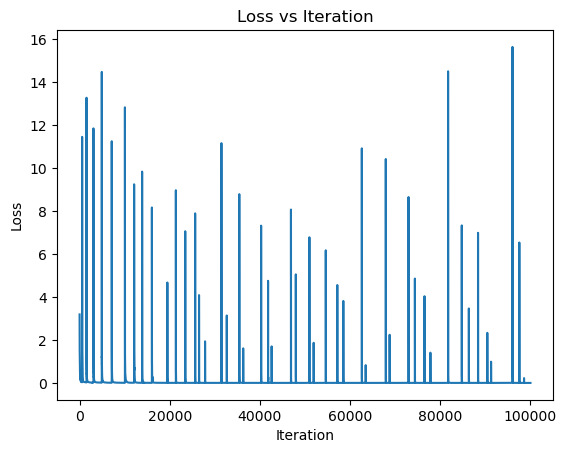

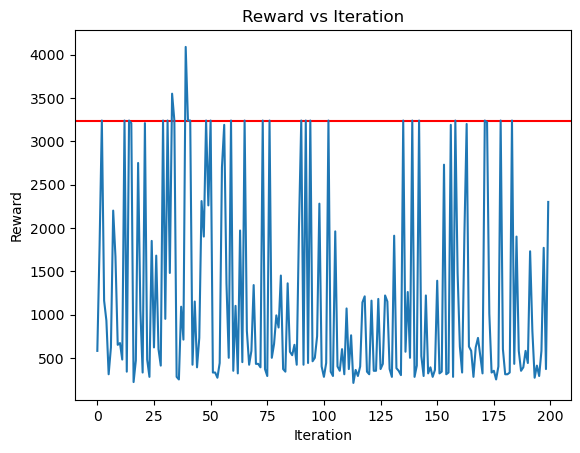

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
# draw a horizontal line at y=3240 which is the expert reward
plt.axhline(y=3240, color='r', linestyle='-', label="Expert Reward")
plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()


